In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, RSTDP_INH_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, load, LAYER_23, LAYER_4, LateralInhibition
from libs.connections import ConnectionWithConvergence, RandomConnection, get_output_size_maxpool1d, BackwardConnections
from libs.network import MultiConnectionNetwork

In [2]:
seed = random.randint(0,9999999)
print(seed)

506888


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Prepare Inputs

In [4]:
input_size_c1 = 200
input_size_c2 = 200
each_session = 40
session_number = 500
categories = 2
# layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train_c1 = torch.zeros(time, input_size_c1).bool()
spike_train_c2 = torch.zeros(time, input_size_c2).bool()
timestep_class = torch.zeros(time)

session_class = torch.randint(0, categories, (session_number, ))
active_fire_rate = 0.17

def fill_spiketrain_from_classes_vector(session_class, spike_train):
    pattern_size = int(input_size_c1/categories)
    for idx, cls in enumerate(session_class):
        passive_noise = torch.rand(each_session, input_size_c1) < 0.01 + (random.random() * 0.01 - 0.005)
        spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise

        pattern = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern[each_session - gap_time:, :] = 0

        spike_train[idx * each_session: (idx + 1) * each_session, pattern_size*cls:pattern_size*(cls + 1)] |= pattern
        timestep_class[idx * each_session: (idx + 1) * each_session] = cls
        
fill_spiketrain_from_classes_vector(session_class, spike_train_c1)
fill_spiketrain_from_classes_vector(session_class, spike_train_c2)

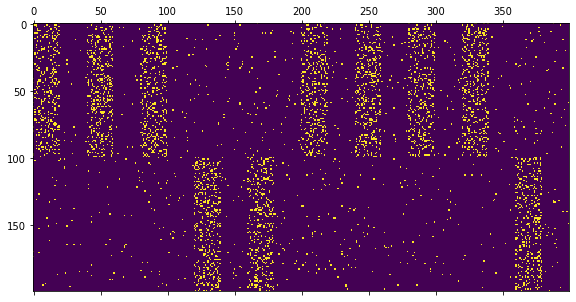

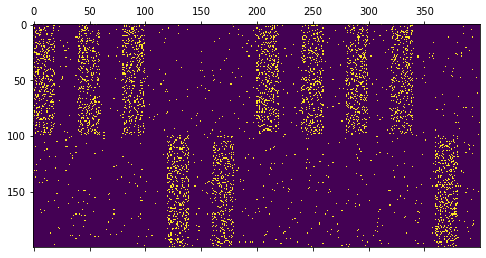

In [5]:
import matplotlib.pyplot as plt

plt.matshow(spike_train_c1.T[:, :10 * each_session])
plt.matshow(spike_train_c2.T[:, :10 * each_session])

# Configs

In [6]:
lr_coef = 1.0

connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 2,
    'weight': 12,
}
layer_args_l23 = {
    'pop_size': get_output_size_maxpool1d(100, 5, 2),
    'inh_con_args': { # Inside Layer
        'wmin': -1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'exc_con_args': {
        'wmin': 2.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'pop_args': {
        'thresh': -56.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
        'noise': (0, 0),
    }
}
layer_args_l4 = { 
    'pop_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'exc_con_args': {
        'wmin': 1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'pop_args': {
        'thresh': -56.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
        'noise': (-1, 1),
    }
}
cc_to_c3_con_args = {
    'wmin': 0.,
    'wmax': 0.7,
    'nu': [0.02 * lr_coef, 0.01 * lr_coef],
#     'update_rule': PostPre,
    'probability': 0.30,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
backward_args_kw = {
    'backward': False,
    'backward_exc_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': 0.,
        'wmax': 0.95,
        'nu': [0.003, 0.007],
        'enable': True,

        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    },
    'backward_inh_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_INH_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': -0.95,
        'wmax': 0,
        'nu': [0.007, 0.003],
        'enable': True,
        'behavior': 'inh',

        'windows_size': 5,
        'windows_std': 0.5,
        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    }
}

input_2_cc = {
    'wmin': 0.,
    'wmax': 0.7,
    'nu': [0.02 * lr_coef, 0.01 * lr_coef],
#     'update_rule': PostPre,
    'probability': 0.50,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 6,
    'tc_minus': 6, 
    'tc_e_trace': 6,
}

connection_type = RandomConnection

In [7]:
# Categories
connection_args_categories = { # Between Layer
    'kernel_size': 5,
    'stride': 2,
    'weight': 12,
}
l4_pop_size_cat = 50
layer_args_l23_categories = {
    'pop_size': get_output_size_maxpool1d(l4_pop_size_cat, 5, 2),
    'inh_con_args': { # Inside Layer
        'wmin': -1,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.5,
    },
    'exc_con_args': {
        'wmin': 1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.7,
    },
    'pop_args': {
        'thresh': -54.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 1,
        'noise': (0, 0),
    }
}
layer_args_l4_categories = {
    'pop_size': l4_pop_size_cat,
    'inh_con_args': { # Inside Layer
        'wmin': -1,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.50,
    },
    'exc_con_args': {
        'wmin': 1.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.7,
    },
    'pop_args': {
        'thresh': -56.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 1,
        'noise': (-1, 1),
    }
}
c3_to_category_cc_con_args = {
    'wmin': 0.,
    'wmax': 0.6,
    'nu': [0.02 * lr_coef, 0.01 * lr_coef],
#     'update_rule': PostPre,
    'probability': 1.0,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
cats_lateral_connection_args = {
    'wmin': -1.0,
    'wmax': 0,
    'update_rule': NoOp,
    'probability': 0.5,
}

# Create Network

In [8]:
model = ComplexStructure()

In [9]:
# CC1 and input
input_pop_c1 = Input(input_size_c1, traces=True, tc_trace=6)
input_name_c1 = f'input_c1'
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c1", monitor=LAYER_23|LAYER_4, **backward_args_kw)
input_to_c1_connection = LayerConnection((input_name_c1, input_pop_c1), c1, connection_type, input_2_cc)
model.add_submodule(c1)
model.add_submodule(input_to_c1_connection)
model.add_pop(input_name_c1, input_pop_c1)

# CC2 and input
input_pop_c2 = Input(input_size_c2, traces=True, tc_trace=6)
input_name_c2 = f'input_c2'
c2 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c2", monitor=LAYER_23|LAYER_4, **backward_args_kw)
input_to_c2_connection = LayerConnection((input_name_c2, input_pop_c2), c2, connection_type, input_2_cc)
model.add_submodule(c2)
model.add_submodule(input_to_c2_connection)
model.add_pop(input_name_c2, input_pop_c2)

In [10]:
# CC3 and connections to
c3 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c3", monitor=LAYER_23|LAYER_4, **backward_args_kw)
c1_c3_connection = LayerConnection(c1, c3, connection_type, cc_to_c3_con_args)
c2_c3_connection = LayerConnection(c2, c3, connection_type, cc_to_c3_con_args)
model.add_submodule(c3)
model.add_submodule(c1_c3_connection)
model.add_submodule(c2_c3_connection)

In [11]:
categories_cc_list = []
c3_to_cat_connections = []

for i in range(categories):
    cc_name = f"c_cat_{i}"
    c_cat = CorticalColumn(connection_args_categories, layer_args_l23_categories, layer_args_l4_categories, name=cc_name, monitor=LAYER_23|LAYER_4, **backward_args_kw)
    c3_cat_connection = LayerConnection(c3, c_cat, connection_type, c3_to_category_cc_con_args)
    c3_to_cat_connections += c3_cat_connection.connections
    categories_cc_list.append((cc_name, c3_cat_connection, c_cat, ))
    model.add_submodule(c_cat)
    model.add_submodule(c3_cat_connection)
    
cats_lateral_connection = LateralInhibition(
    ccs=[cc_tuple[2] for cc_tuple in categories_cc_list],
    connection_args=cats_lateral_connection_args,
    connection_type=connection_type
)
model.add_submodule(cats_lateral_connection)

In [12]:
network = MultiConnectionNetwork(dt=1.0)
model.add_to_network(network)

In [13]:
bl_monitors = []
bl_monitors_name = []
for a, b, con in c3_to_cat_connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

In [14]:
# bl_monitors = []
# bl_monitors_name = []
# for a, b, con in c1_c3_connection.connections + c2_c3_connection.connections:
#     tmp = Monitor(obj=con, state_vars=['converge'])
#     network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
#     bl_monitors.append(tmp)
#     bl_monitors_name.append((a, b))
    

# Run Network


In [15]:
def get_all_backward_trigger_connections():
    cotrical_columns_list = [c1, c2, c3] + [cc for _, _, cc in categories_cc_list]
    cons = []
    for cc in cotrical_columns_list:
        if cc.backward_exc_connection:
            cons += cc.backward_exc_connection.get_connections()
        if cc.backward_inh_connection:
            cons += cc.backward_inh_connection.get_connections()
    return cons

def get_all_forward_trigger_connections():
    cat_cons = []
    for _, con, _ in categories_cc_list:
        cat_cons += con.get_connections()
    return (
        cat_cons +
        input_to_c1_connection.get_connections() +
        input_to_c2_connection.get_connections() +
        c1_c3_connection.get_connections() +
        c2_c3_connection.get_connections()
    )

def get_all_trigger_connections():
    return get_all_backward_trigger_connections() + get_all_forward_trigger_connections()

In [16]:
get_all_forward_trigger_connections()

[('c3_l23__pop',
  'c_cat_0_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )),
 ('c3_l23__pop',
  'c_cat_1_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )),
 ('input_c1',
  'c1_l4__pop',
  RandomConnection(
    (source): Input()
    (target): NoisyLIFNode()
  )),
 ('input_c2',
  'c2_l4__pop',
  RandomConnection(
    (source): Input()
    (target): NoisyLIFNode()
  )),
 ('c1_l23__pop',
  'c3_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )),
 ('c2_l23__pop',
  'c3_l4__pop',
  RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ))]

In [17]:
from tqdm import trange

rewards = []
reward_window = 10
winner = []
changes = []
# activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c3.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c3.l23.enable_learning()
#         c3.l4_l23.enable_learning()
    
    
    inp = {
        input_name_c1: spike_train_c1[part*each_session:part*each_session+each_session, :],
        input_name_c2: spike_train_c2[part*each_session:part*each_session+each_session, :],
    }
    network.run(inputs=inp, time=each_session)
    
#     avg_sessions = 10
#     in_use_sessions = min(part + 1, avg_sessions)
#     exc1_avg = c3.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
#     exc2_avg = c3.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions

    activities = []
    for name, con, cc in categories_cc_list:
        activity = cc.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()
        activities.append((name, activity))
    # Find Maxinum Active Pop.
    max_index, max_value = -1, -1
    for idx, activity_pack in enumerate(activities):
        _, activity = activity_pack
        if activity > max_value:
            max_value = activity
            max_index = idx
    # Find Second Maxinum Active Pop.  
    sec_max_index, sec_max_value = -1, -1
    for idx, activity_pack in enumerate(activities):
        _, activity = activity_pack
        if idx == max_index:
            continue
        if activity > sec_max_value:
            sec_max_value = activity
            sec_max_index = idx
    
#     exc1_act = c3.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
#     exc2_act = c3.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
#     activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]  # Pattern Index
#     gap = abs(max_value - sec_max_value) / layer_args_l23_categories['pop_size'] # categories_l23_pop_size  #  In Range 0-1
#     gap_check = gap > 0.2
#     max_pos_activity = (layer_args_l23_categories['pop_size'] * each_session)
#     gap = abs(max_value - sec_max_value) / max_pos_activity
    
    gap = 5 * abs(max_value - sec_max_value) / (max_value + sec_max_value)
    
#     exc1_wins = exc1_act > exc2_act
    
#     if pattern == exc1_wins and gap_check:
#         reward = 1.0 + gap
#     elif pattern == exc1_wins:
#         reward = -0.5 + gap
#     else:
#         reward = -1 - gap

#     if gap_check:
#         reward = 0
    winnders_num = sum(winner[-reward_window:])
    pos_coef = 1 - winnders_num / reward_window
    neg_coef = winnders_num / reward_window

    
    if max_index == pattern: # and gap_check:
        reward = min(gap * pos_coef, 7)
    else:
        reward = max(-gap * neg_coef, -7)
        
    rewards.append(reward)
    winner.append(max_index == pattern)
    
    for conn in get_all_trigger_connections():
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:15<00:00,  3.69parts/s]


In [18]:
rewards

[tensor(0.3535),
 tensor(2.2895),
 tensor(3.5897),
 tensor(-1.5000),
 tensor(-1.5000),
 tensor(3.5000),
 tensor(3.),
 tensor(2.5000),
 tensor(2.0000),
 tensor(-3.5000),
 tensor(-3.5000),
 tensor(1.3719),
 tensor(1.9192),
 tensor(-3.),
 tensor(2.0000),
 tensor(1.3710),
 tensor(-3.2083),
 tensor(1.9714),
 tensor(-2.9520),
 tensor(2.5000),
 tensor(-3.),
 tensor(1.9708),
 tensor(-3.),
 tensor(-2.5000),
 tensor(-1.8478),
 tensor(-1.8400),
 tensor(0.5833),
 tensor(1.4000),
 tensor(2.6667),
 tensor(-2.4367),
 tensor(2.3793),
 tensor(0.5952),
 tensor(2.3039),
 tensor(2.0000),
 tensor(-3.5000),
 tensor(1.5000),
 tensor(-4.),
 tensor(0.5526),
 tensor(1.5000),
 tensor(-1.9688),
 tensor(1.5000),
 tensor(1.4286),
 tensor(1.4423),
 tensor(1.2170),
 tensor(1.4524),
 tensor(0.9753),
 tensor(-4.),
 tensor(0.9474),
 tensor(0.7500),
 tensor(0.7143),
 tensor(0.3750),
 tensor(0.3704),
 tensor(0.3333),
 tensor(-2.8019),
 tensor(-3.2195),
 tensor(1.5000),
 tensor(1.5000),
 tensor(-3.8049),
 tensor(1.5000),
 

('c3_l23__pop', 'c_cat_0_l4__pop')
('c3_l23__pop', 'c_cat_1_l4__pop')


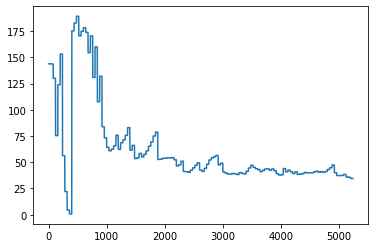

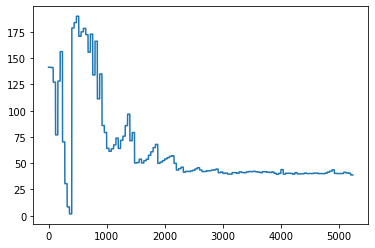

In [19]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

# Visualization

In [20]:
time_show = time

spikes = {
    "C1 | L4": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C1 | L23": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    
    "C2 | L4": c2.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C2 | L23": c2.l23.monitors[0][1].get('s')[-time_show:,0,:].T,
    
    "C3 | L4": c3.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C3 | L23": c3.l23.monitors[0][1].get('s')[-time_show:,0,:].T,
}

for name, _, cc in categories_cc_list:
    spikes[f"{name} | L4"] = cc.l4.monitors[0][1].get('s')[-time_show:,0,:].T
    spikes[f"{name} | L23"] = cc.l23.monitors[0][1].get('s')[-time_show:,0,:].T
spikes

{'C1 | L4': tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 'C1 | L23': tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 'C2 | L4': tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...

In [21]:
def show_spikes(time, spikes_name, fig_size=(10,14)):
    nos = len(spikes_name)
    x = time
    fig, axs = plt.subplots(1, nos, figsize=fig_size)
    for name, ax in zip(spikes_name, axs):
        ax.matshow(spikes[name][:, x * each_session:x * each_session + each_session])
        ax.set_title(name)
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')

In [22]:
start_of_range = session_number
start_of_range = 110
visualization_range = range(start_of_range - 10, start_of_range)

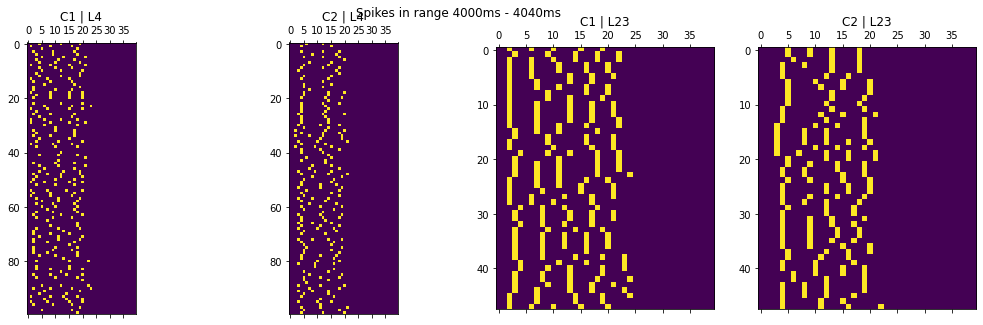

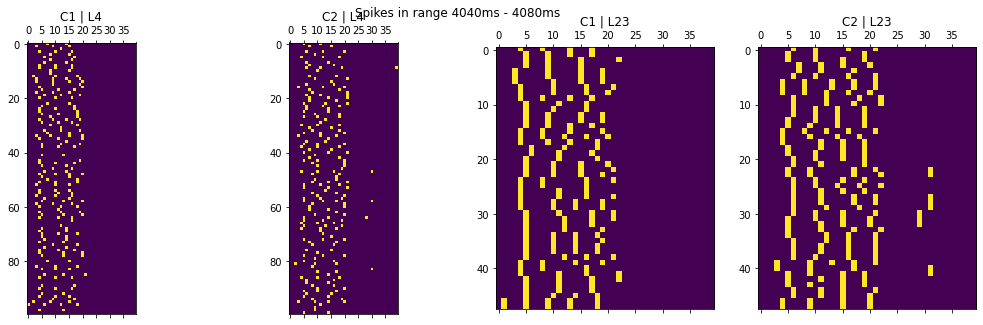

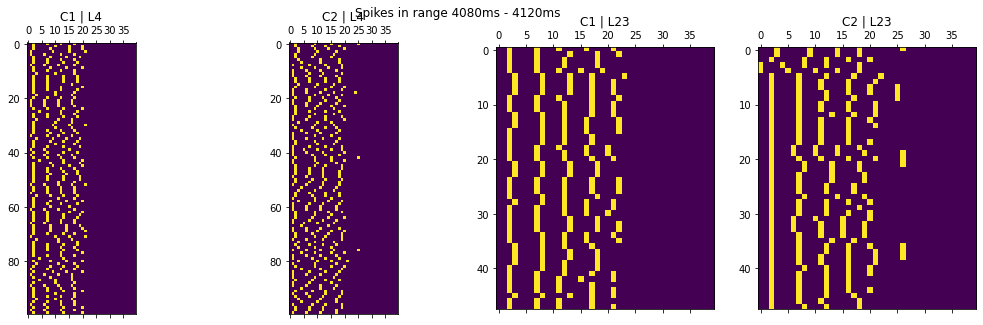

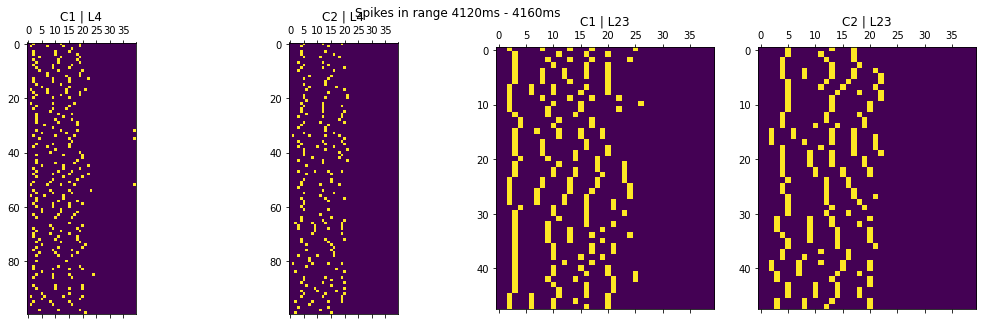

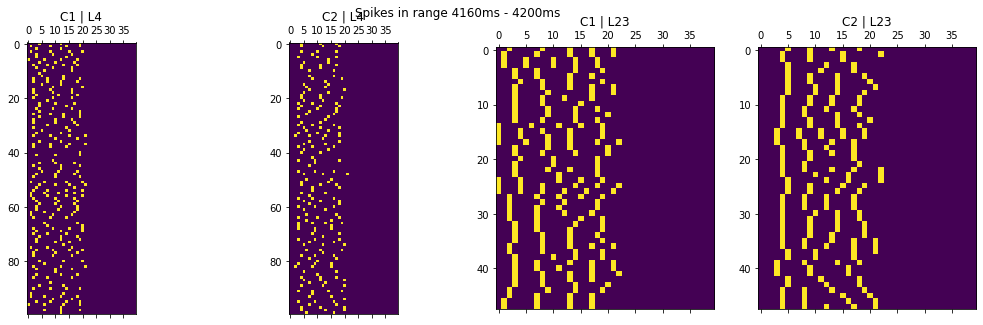

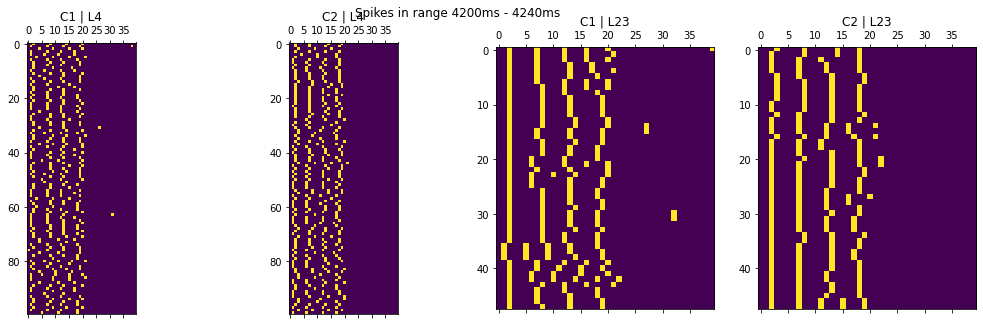

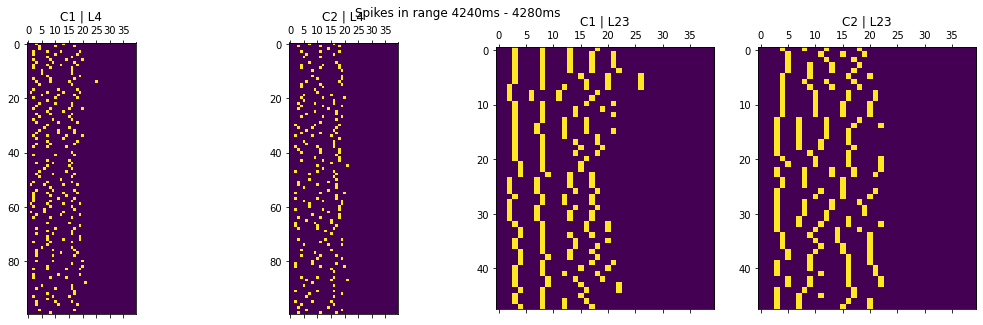

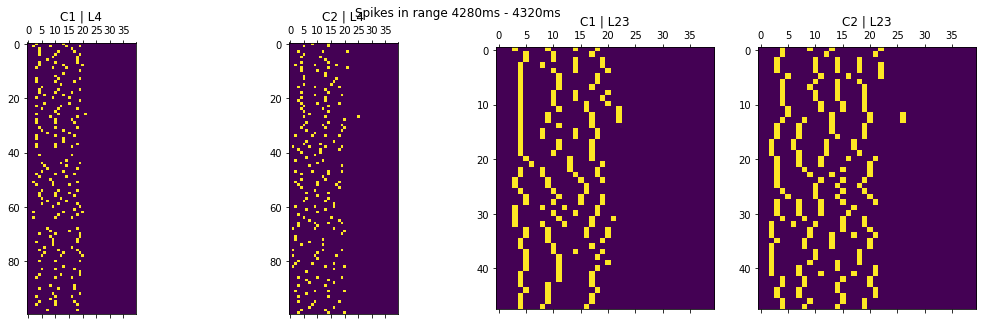

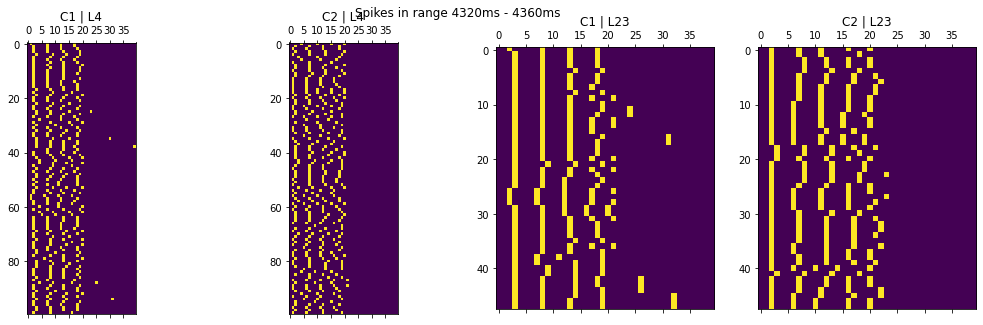

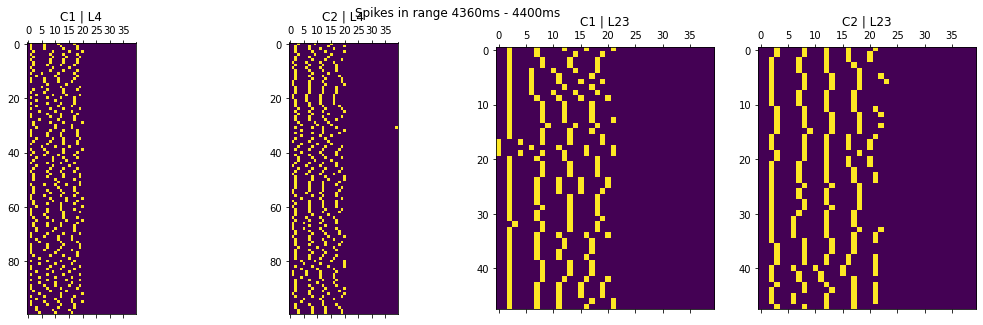

In [23]:
for i in visualization_range:
    show_spikes(i, ["C1 | L4", "C2 | L4", "C1 | L23", "C2 | L23"], fig_size=(18,5)) 

tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)


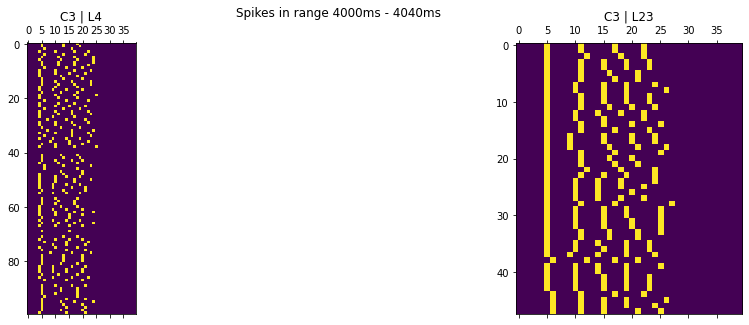

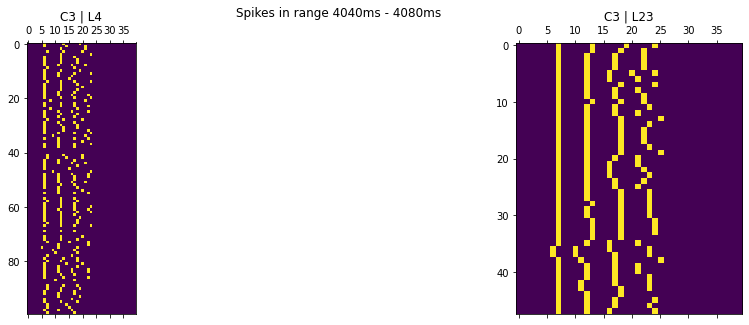

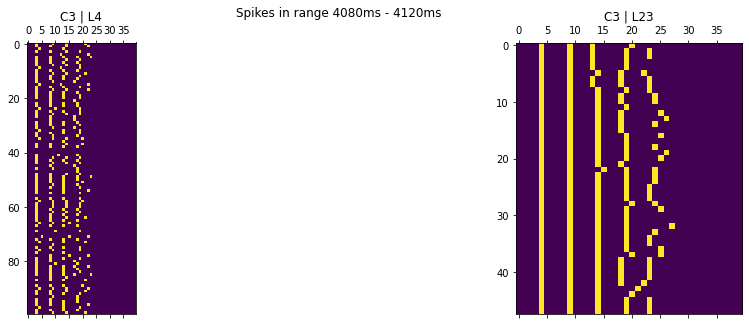

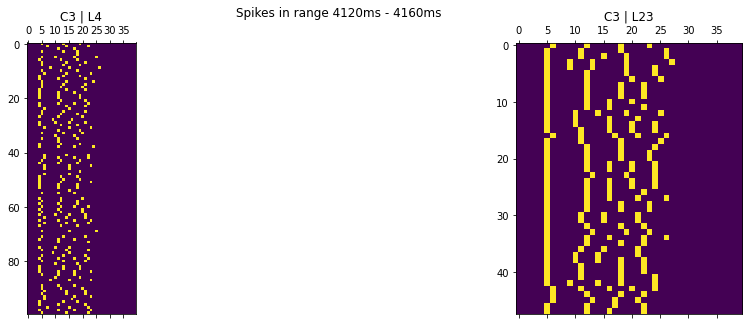

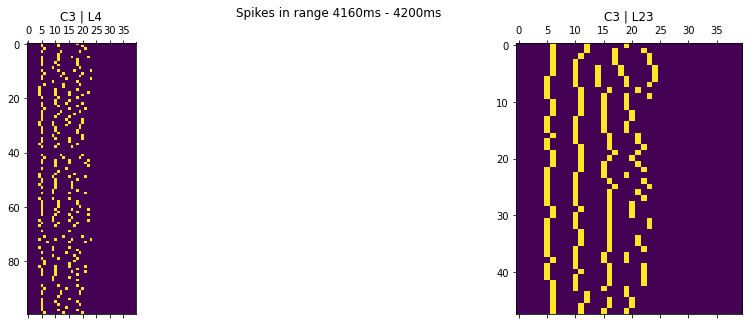

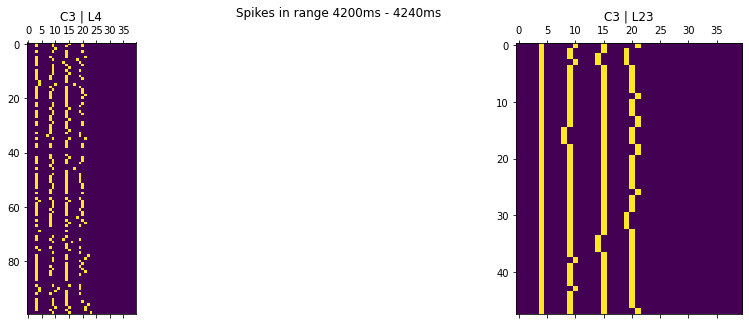

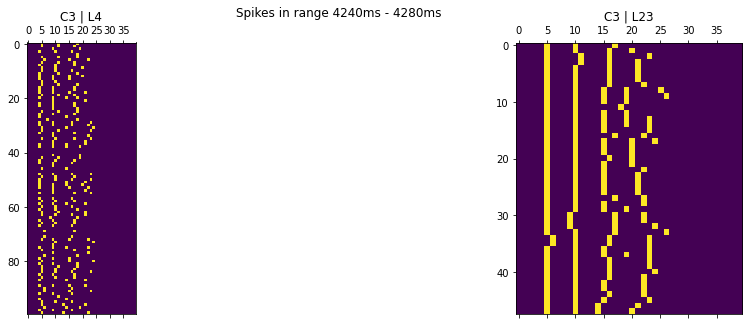

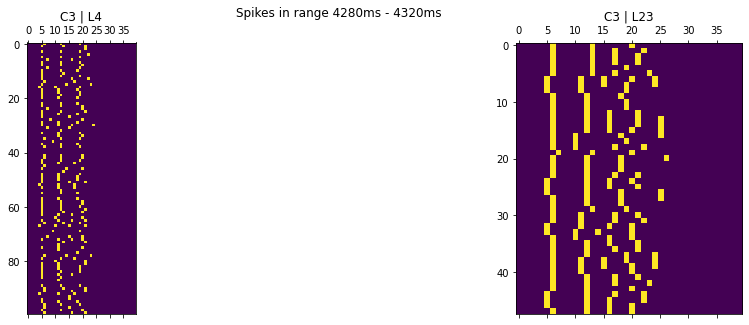

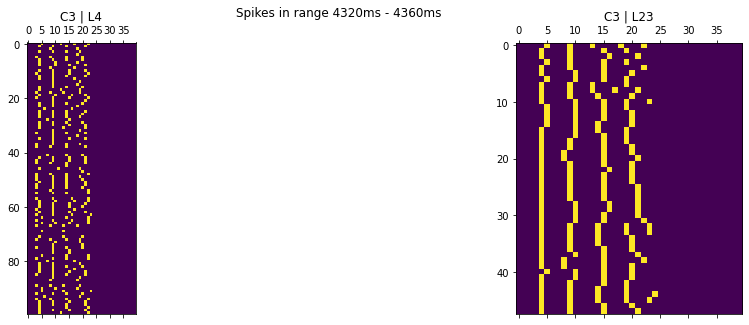

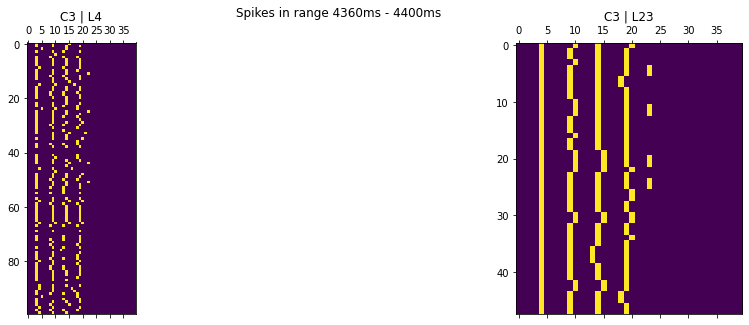

In [24]:
for i in visualization_range:
    show_spikes(i, ["C3 | L4", "C3 | L23"], fig_size=(18,5))
    print(session_class[i])

tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(-4.)
tensor(-4.)
tensor(1.2750)
tensor(-3.1111)
tensor(-2.2800)
tensor(1.5000)
tensor(-2.1429)
tensor(0.8333)
tensor(0.2778)
tensor(2.1154)


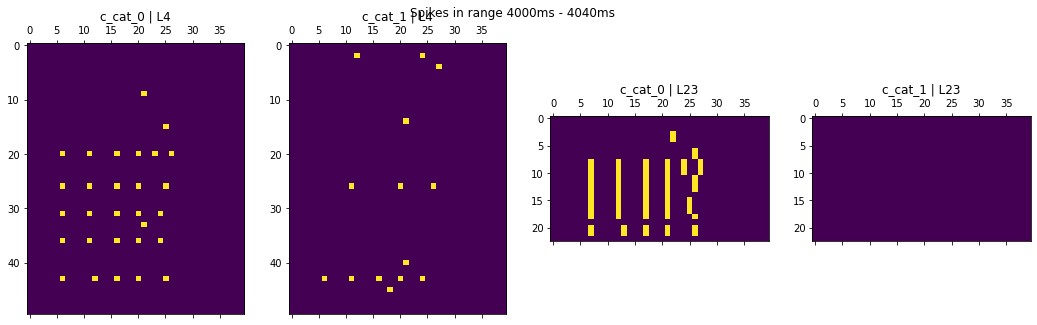

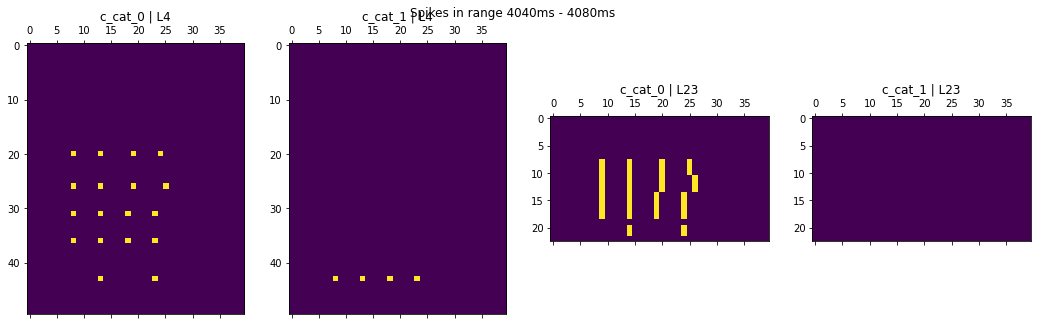

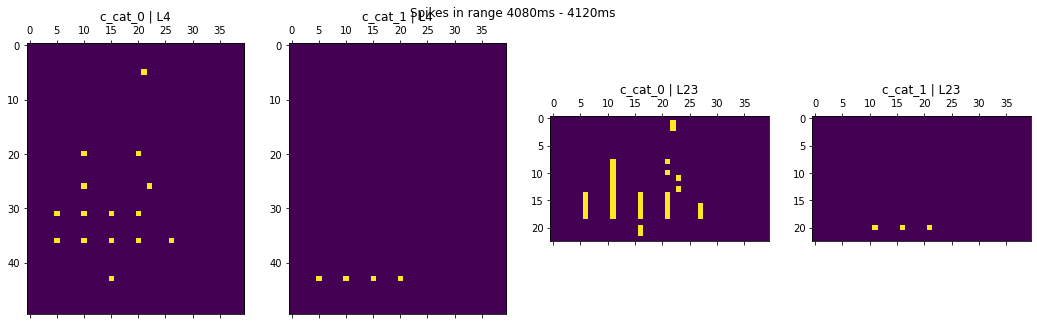

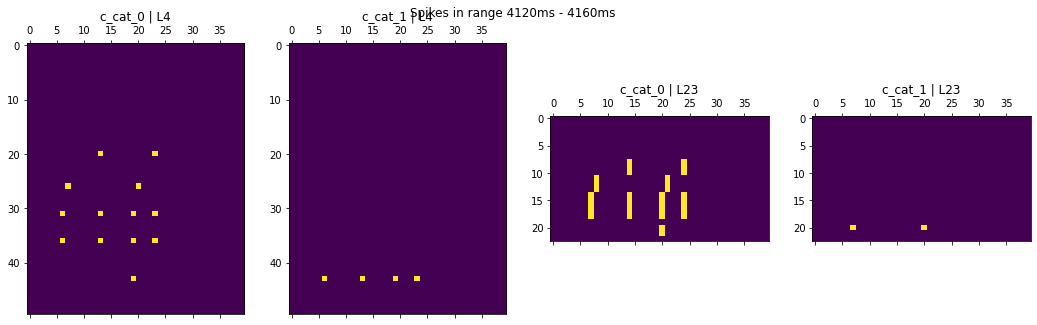

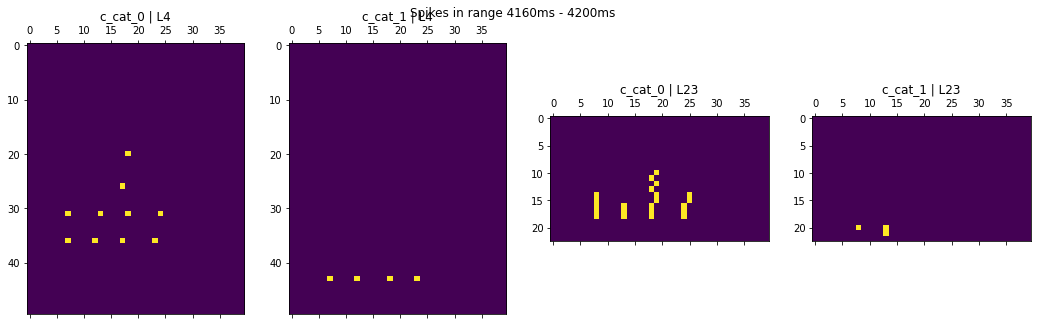

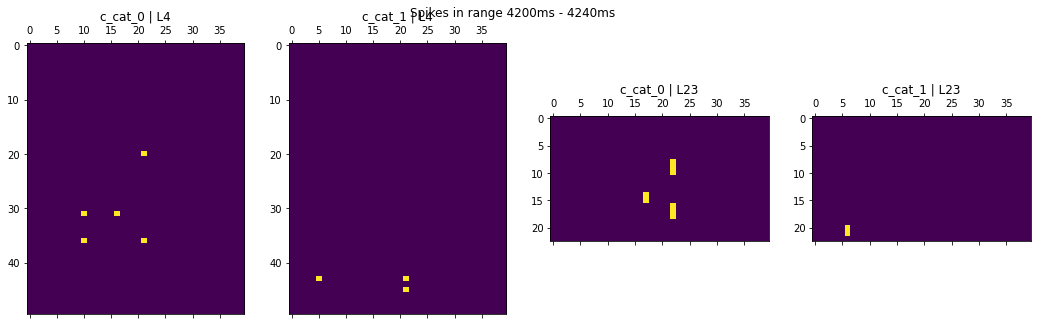

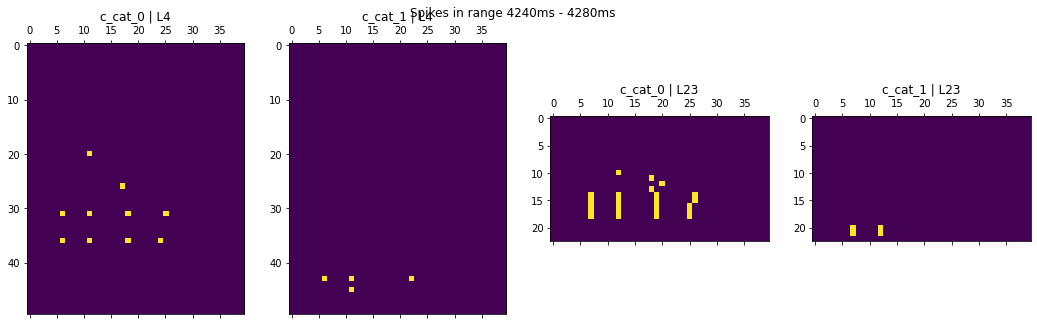

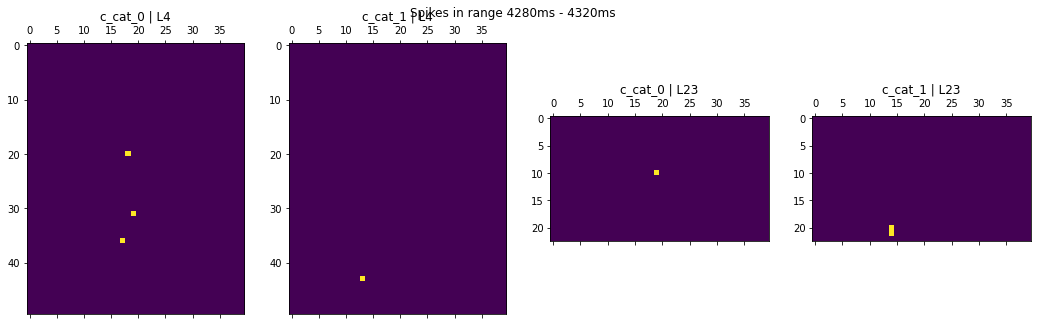

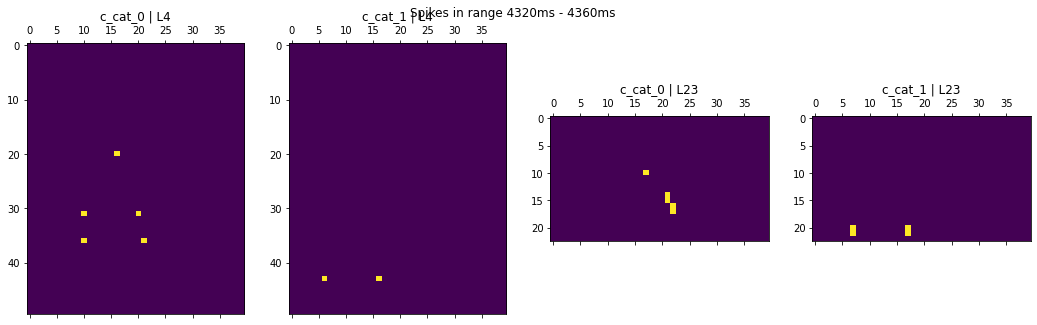

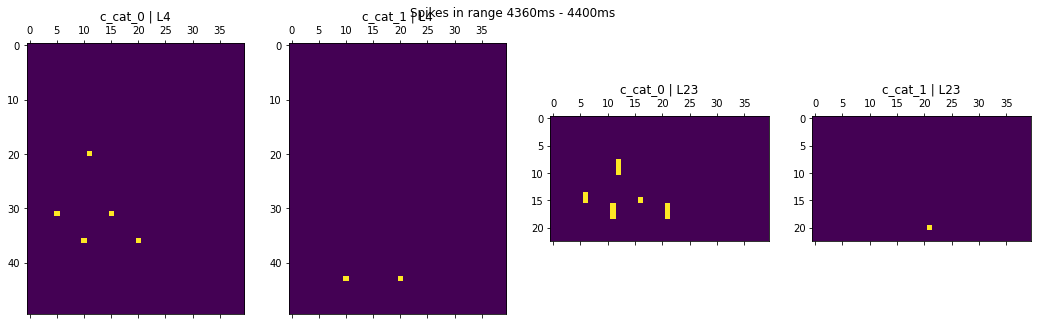

In [25]:
for i in visualization_range:
    show_spikes(i, ["c_cat_0 | L4", "c_cat_1 | L4", "c_cat_0 | L23", "c_cat_1 | L23"], fig_size=(18,5))
    print(session_class[i])
    
print("=============")
for i in visualization_range:
    print(rewards[i])

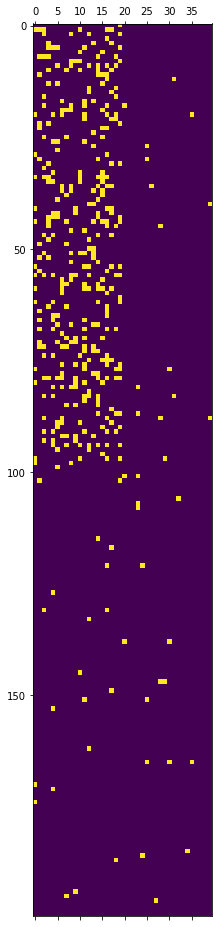

In [26]:
plt.matshow(spike_train_c1.T[:, :1 * each_session])

In [27]:
network.connections

{('c1_l4__pop',
  'c1_l23__pop'): [MaxPool1dConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c1_l23__pop',
  'c1_l23__pop'): [RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ), RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c1_l4__pop',
  'c1_l4__pop'): [RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ), RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('input_c1',
  'c1_l4__pop'): [RandomConnection(
    (source): Input()
    (target): NoisyLIFNode()
  )],
 ('c2_l4__pop',
  'c2_l23__pop'): [MaxPool1dConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c2_l23__pop',
  'c2_l23__pop'): [RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  ), RandomConnection(
    (source): NoisyLIFNode()
    (target): NoisyLIFNode()
  )],
 ('c2_l4__pop',
  'c2_l4__pop'): [RandomConnection(
    (s